In [1]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

from torchsummary import summary

from utils.data_utils import *
from model.encoder import Encoder
from model.generator import Generator
from model.discriminator import Discrimator

import matplotlib.pyplot as plt

In [2]:
def weight_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv3d') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

# Args

In [3]:
choose_cuda = True
data_dir = '/home/ewok261/Documents/psychic-gan/data/in_2_out_1_ol_0'
frm_in = 2
frm_out = 1
mini_batch = 32
n_epochs = 200

In [4]:
if choose_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


# Load data

In [5]:
all_data = KITTIData(frm_in, frm_out, 0, data_dir)
[train_data,val_data] = data.random_split(all_data, [1100, 243])
[train_data, _] = data.random_split(train_data, [10, 1090]) # take a small subset of training data (for overfitting)
[val_data, _] = data.random_split(val_data, [30, 213])
train_loader = data.DataLoader(train_data, batch_size = 4, shuffle=True, num_workers=1)
val_loader = data.DataLoader(val_data, batch_size = 1, shuffle = False, num_workers = 1)
print('Train size: {0}'.format(len(train_data)))
print('Val size: {0}'.format(len(val_data)))

Train size: 10
Val size: 30


# Define the network and loss

In [6]:
loss_fun = nn.MSELoss()

encoder = Encoder(frame_dim=64, init_temp=2, hidden_dim=128, out_filters=256,
                  attention_at=8, norm=nn.utils.weight_norm, residual=True)
encoder = encoder.to(device)
encoder_optim = optim.Adam(encoder.parameters(), betas=(0.9, 0.999))

generator = Generator(frame_dim=64, temporal_target=1, hidden_dim=128,
                      init_filters=256, attention_at=32, norm=nn.utils.weight_norm)
generator = generator.to(device)
generator_optim = optim.Adam(generator.parameters(), betas=(0.9, 0.999))

encoder.apply(weight_init)
generator.apply(weight_init)

summary(encoder, input_size=(3, frm_in, 64, 64))
summary(generator, input_size=(128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 32, 1, 32, 32]           2,624
         LeakyReLU-2        [-1, 32, 1, 32, 32]               0
        NormConvND-3        [-1, 32, 1, 32, 32]               0
            Conv3d-4        [-1, 32, 1, 32, 32]             128
         LeakyReLU-5        [-1, 32, 1, 32, 32]               0
        NormConvND-6        [-1, 32, 1, 32, 32]               0
ResidualNormConv3D-7        [-1, 32, 1, 32, 32]               0
            Conv3d-8        [-1, 64, 1, 16, 16]          55,360
         LeakyReLU-9        [-1, 64, 1, 16, 16]               0
       NormConvND-10        [-1, 64, 1, 16, 16]               0
           Conv3d-11        [-1, 64, 1, 16, 16]           2,112
        LeakyReLU-12        [-1, 64, 1, 16, 16]               0
       NormConvND-13        [-1, 64, 1, 16, 16]               0
ResidualNormConv3D-14        [-1, 64, 1

# Training loop

In [7]:
train_hist_real = []
train_hist_gen = []
val_hist = []
for epoch in range(n_epochs):
        running_loss_gen = 0.0
        running_loss_real = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs and move them to device
            in_frames, out_frames = data
            in_frames = in_frames.to(device)
            out_frames = out_frames.to(device)
            
            # zero the parameter gradients
            encoder.zero_grad()
            generator.zero_grad()
            
            # GENERATOR/ENCODER TRAINING
            hidden, encoder_attn = encoder(in_frames)
            generated, generator_attn = generator(hidden)
            
            loss_gen = loss_fun(generated, out_frames)
            
            loss_gen.backward()
            encoder_optim.step()
            generator_optim.step()

            # print statistics
            running_loss_gen += loss_gen.item() / 3
            if i % 3 == 2:
                print('[Epoch {0} - Step {1}] R-loss: {2} G-loss: {3}'.format(epoch, i, running_loss_real, running_loss_gen))
                train_hist_real.append(running_loss_real)
                train_hist_gen.append(running_loss_gen)
                running_loss_real = 0
                running_loss_gen = 0

        val_loss = 0.0
        for in_frames, out_frames in val_loader:
            # get the validation inputs and outputs
            in_frames = in_frames.to(device)
            out_frames = out_frames.to(device)
            
            # forward
            with torch.no_grad():
                hidden, encoder_attn = encoder(in_frames)
                generated, generator_attn = generator(hidden)
            
            val_loss += loss_fun(generated, out_frames).item() / len(val_loader)
            #val_loss += loss_fun(generated, out_frames).item() / len(val_loader)

        print('[Epoch {0}] Val-Loss: {1}'.format(epoch, val_loss))
        val_hist.append(val_loss)

[Epoch 0 - Step 2] R-loss: 0.0 G-loss: 0.22926876942316693
[Epoch 0] Val-Loss: 1.853477172056834
[Epoch 1 - Step 2] R-loss: 0.0 G-loss: 0.741381878654162
[Epoch 1] Val-Loss: 0.21805999403198556
[Epoch 2 - Step 2] R-loss: 0.0 G-loss: 0.25182423492272693
[Epoch 2] Val-Loss: 0.2151196370522181
[Epoch 3 - Step 2] R-loss: 0.0 G-loss: 0.23480741182963055
[Epoch 3] Val-Loss: 0.1995626139144103
[Epoch 4 - Step 2] R-loss: 0.0 G-loss: 0.21128758788108826
[Epoch 4] Val-Loss: 0.12463799764712648
[Epoch 5 - Step 2] R-loss: 0.0 G-loss: 0.12516286224126816
[Epoch 5] Val-Loss: 0.09735206613938012
[Epoch 6 - Step 2] R-loss: 0.0 G-loss: 0.10101482520500818
[Epoch 6] Val-Loss: 0.08940692742665607
[Epoch 7 - Step 2] R-loss: 0.0 G-loss: 0.09113586197296777
[Epoch 7] Val-Loss: 0.0912138303120931
[Epoch 8 - Step 2] R-loss: 0.0 G-loss: 0.08791237076123555
[Epoch 8] Val-Loss: 0.08343812661866347
[Epoch 9 - Step 2] R-loss: 0.0 G-loss: 0.08773323645194372
[Epoch 9] Val-Loss: 0.08062010246018568
[Epoch 10 - Step 

[Epoch 81] Val-Loss: 0.045864154212176794
[Epoch 82 - Step 2] R-loss: 0.0 G-loss: 0.0297707070906957
[Epoch 82] Val-Loss: 0.049490738101303576
[Epoch 83 - Step 2] R-loss: 0.0 G-loss: 0.03215284769733747
[Epoch 83] Val-Loss: 0.046998758614063274
[Epoch 84 - Step 2] R-loss: 0.0 G-loss: 0.033044678469498955
[Epoch 84] Val-Loss: 0.04854470007121562
[Epoch 85 - Step 2] R-loss: 0.0 G-loss: 0.03502575680613518
[Epoch 85] Val-Loss: 0.048250176136692344
[Epoch 86 - Step 2] R-loss: 0.0 G-loss: 0.05177606207629045
[Epoch 86] Val-Loss: 0.06754997335374355
[Epoch 87 - Step 2] R-loss: 0.0 G-loss: 0.06368602439761162
[Epoch 87] Val-Loss: 0.0557265043258667
[Epoch 88 - Step 2] R-loss: 0.0 G-loss: 0.04968917618195216
[Epoch 88] Val-Loss: 0.07703706460694472
[Epoch 89 - Step 2] R-loss: 0.0 G-loss: 0.0631290152668953
[Epoch 89] Val-Loss: 0.057023604462544134
[Epoch 90 - Step 2] R-loss: 0.0 G-loss: 0.052369688947995506
[Epoch 90] Val-Loss: 0.0552579282472531
[Epoch 91 - Step 2] R-loss: 0.0 G-loss: 0.04899

[Epoch 161 - Step 2] R-loss: 0.0 G-loss: 0.02067772795756658
[Epoch 161] Val-Loss: 0.047248469789822896
[Epoch 162 - Step 2] R-loss: 0.0 G-loss: 0.020813789839545887
[Epoch 162] Val-Loss: 0.04486127154280742
[Epoch 163 - Step 2] R-loss: 0.0 G-loss: 0.019572439913948376
[Epoch 163] Val-Loss: 0.04679474582274755
[Epoch 164 - Step 2] R-loss: 0.0 G-loss: 0.021990794067581497
[Epoch 164] Val-Loss: 0.04547629499187072
[Epoch 165 - Step 2] R-loss: 0.0 G-loss: 0.021261760964989662
[Epoch 165] Val-Loss: 0.04564621224999429
[Epoch 166 - Step 2] R-loss: 0.0 G-loss: 0.020063195377588272
[Epoch 166] Val-Loss: 0.04620677214115859
[Epoch 167 - Step 2] R-loss: 0.0 G-loss: 0.020493844524025917
[Epoch 167] Val-Loss: 0.04562620421250661
[Epoch 168 - Step 2] R-loss: 0.0 G-loss: 0.020904471476872764
[Epoch 168] Val-Loss: 0.04597656708210707
[Epoch 169 - Step 2] R-loss: 0.0 G-loss: 0.019575420767068863
[Epoch 169] Val-Loss: 0.04561846833676099
[Epoch 170 - Step 2] R-loss: 0.0 G-loss: 0.019449302305777866
[E

# Results visualization

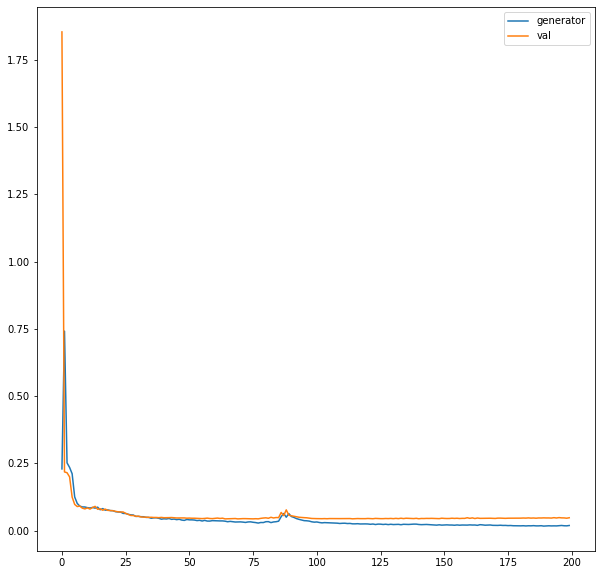

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(train_hist_gen)
plt.plot(val_hist)
plt.legend(['generator', 'val'])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 2, 64, 64])
torch.Size([1, 3, 1, 64, 64])


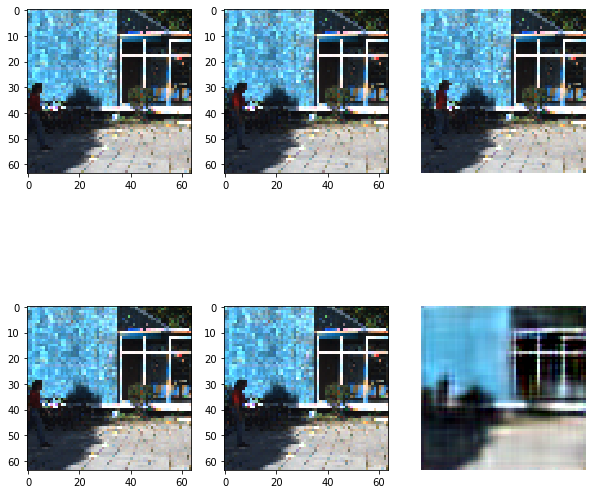

In [9]:
insamp, outsamp = train_data[0]
insamp = insamp.unsqueeze(0)
outsamp = outsamp.unsqueeze(0)
print(insamp.shape)
print(outsamp.shape)
insamp, outsamp = insamp.to(device), outsamp.to(device)

with torch.no_grad():
    hidval, encval_attn = encoder(insamp)
    genval, genval_attn = generator(hidval)

insamp = insamp.cpu().squeeze().permute(1,2,3,0).numpy()
genval = genval.cpu().squeeze().permute(1,2,0).detach().numpy()
outsamp = outsamp.cpu().squeeze().permute(1,2,0).numpy()

plt.figure(figsize=(10, 10))
# img
plt.subplot(2, frm_in+frm_out, 1)
plt.imshow(insamp[0])
plt.subplot(2, frm_in+frm_out, 2)
plt.imshow(insamp[1])
plt.subplot(2, frm_in+frm_out, 3)
plt.imshow(outsamp)
plt.axis('off')

# target
plt.subplot(2, frm_in+frm_out, 4)
plt.imshow(insamp[0])
plt.subplot(2, frm_in+frm_out, 5)
plt.imshow(insamp[1])
plt.subplot(2, frm_in+frm_out, 6)
plt.imshow(genval)
plt.axis('off')
plt.show()

In [10]:
encval_attn = encval_attn.cpu().squeeze().detach().numpy()
genval_attn = genval_attn.cpu().squeeze().detach().numpy()
print(encval_attn.shape)
print(genval_attn.shape)

(128, 8, 8)
(32, 32, 32)


In [11]:
print(encval_attn[0,:,:])

[[ 0.00910363  0.02634264 -0.02477346 -0.01521413 -0.01012466 -0.0069595
  -0.01604125  0.01625475]
 [-0.0303423   0.00304633 -0.01307881 -0.01853211 -0.00505404 -0.01420967
  -0.02406268  0.01118277]
 [-0.00206773 -0.00952611 -0.01643142 -0.01243729 -0.01046195 -0.00821294
  -0.00127415 -0.00346661]
 [-0.00627164 -0.01144501 -0.03150798  0.00307401 -0.01198804  0.00246247
   0.0017764   0.0057604 ]
 [-0.01301856  0.00131591 -0.03027269 -0.04586733 -0.00995543  0.02001008
  -0.00582043 -0.0039709 ]
 [-0.01083895 -0.01194285 -0.02473236 -0.00619037 -0.03825978 -0.01523539
  -0.0262058  -0.00183111]
 [-0.02546205  0.00924638 -0.00928247 -0.01113916 -0.01787794 -0.00565908
   0.00947103 -0.00249113]
 [ 0.00913513  0.00932325 -0.03339885 -0.00491493 -0.04137348 -0.00838054
  -0.01567765  0.0123722 ]]


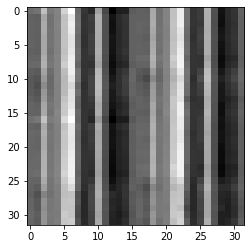

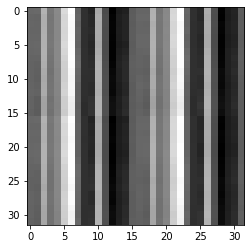

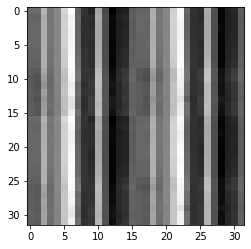

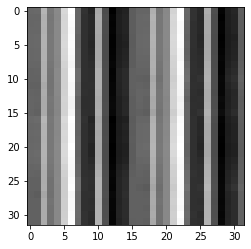

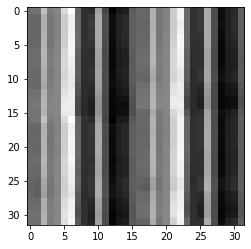

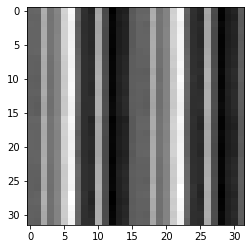

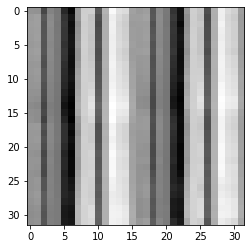

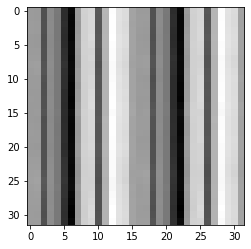

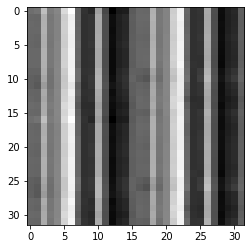

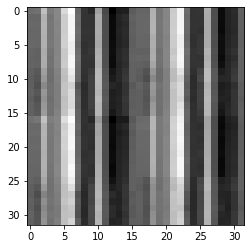

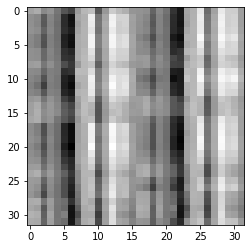

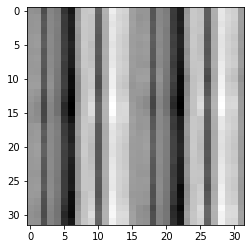

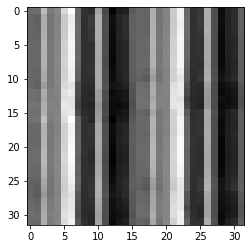

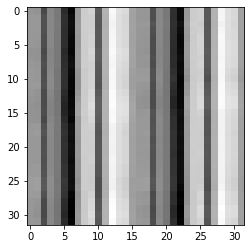

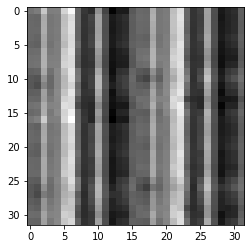

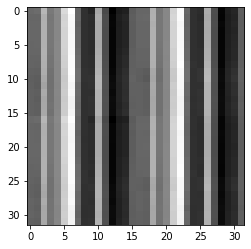

In [14]:
for idx in range(16):#genval_attn.shape[0]):
    plt.imshow(genval_attn[idx,:,:], cmap = 'gray')
    plt.show()